# Mobile price classification with multilayer perceptron
## Tensorflow
Erik Matovič and Jakub Horvat

[Dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv)

Predict a price range indicating how high the price is

### 0. Imports

In [252]:
from utils import split_train_val
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from sklearn.model_selection import train_test_split
from utils import check_null_values, print_sum_null, rescale, split_data

In [253]:
# api = wandb.Api()
# sweep = api.sweep("xmatovice/uncategorized/1stel95e") #2hfg3dq6") #1kmqujzs")
#
# best_config = sweep.best_run().config
# pprint(best_config)
#
# wandb.init(config=best_config, project='uncategorized', name='NSIETE_zad1_final')
# config = wandb.config

In [254]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))


2.11.0
Num GPUs Available:  0
tf.Tensor(546.0383, shape=(), dtype=float32)
[]


In [255]:
wandb.login()
run=wandb.init(project="nsiete1")

### 1. Data Preprocessing

Based on [exploratory data analysis](EDA.ipynb) test set does not have target variable price_range. We split our dataset into train-dev-test. We have train and test sets, but we split test set by half to dev-test sets. We will rougly have train-dev-test 67%-16.5%-16.5%. 

In [256]:
# read datasets
df_train = pd.read_csv('../data/train.csv', sep=',')
df_train


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [257]:
df_test = pd.read_csv('../data/test.csv', sep=',', index_col=0)
#df_test

In [258]:
df_train.values

array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        2.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        2.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 0.000e+00,
        3.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        3.000e+00]])

In [259]:
x_train = df_train.values[:, :-1]       #vsetko okrem price range
x_train = x_train.astype('float32')     # input data as floats
#x_train

In [260]:
y_train = df_train.values[:, -1]  # price range
y_train = y_train.astype('int')
print(y_train)

[1 2 2 ... 3 0 3]


In [261]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=52)
print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)
#print(y_train," sad")
class_labels = [0, 1, 2, 3]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_labels))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(class_labels))
print(y_train)

(1600, 20) (400, 20) (1600,) (400,)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [262]:
x_test = df_test.values[:, :]       #vsetko okrem price range
x_test = x_test.astype('float32')
x_test

array([[1.043e+03, 1.000e+00, 1.800e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [8.410e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.807e+03, 1.000e+00, 2.800e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [1.185e+03, 0.000e+00, 1.400e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.533e+03, 1.000e+00, 5.000e-01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.270e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        1.000e+00]], dtype=float32)

In [263]:
model = keras.Sequential([
    # keras.layers.Input(shape=(20,),name='input'),
    keras.layers.Dense(256,input_shape=(20,),activation='relu',name='l1'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(256,activation='relu',name='l2'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(256,activation='relu',name='l3'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(256,activation='relu',name='l4'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(4,activation='sigmoid',name='l5') #activation='sigmoid'
])


In [264]:
lr = 0.03648030109469176
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy','mse']
              )


In [265]:
tf.debugging.enable_traceback_filtering()
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(x_val,y_val),
                    callbacks=[
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models")
                    ],
                    verbose=0)

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.3s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.3s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


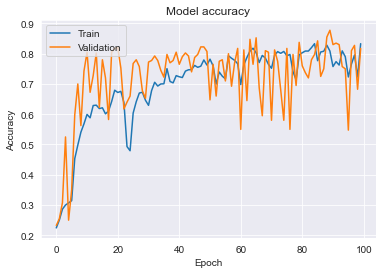

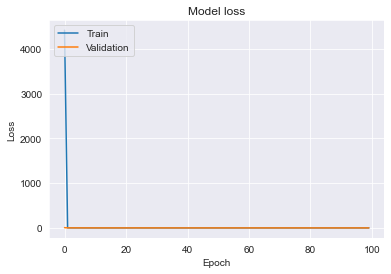

In [266]:
import matplotlib.pyplot as plt

#Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# # Plot training & validation categorical accuracy
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('Model categorical accuracy')
# plt.ylabel('Categorical accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [267]:
#from sklearn import confusion_matrix
#confusion_matrix(y_val,history.value)

In [268]:
wandb.finish()


accuracy,▁▂▂▄▅▆▆▅▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▆█▇▇███▇████▇█▇█
batch/accuracy,▂▂▁▄▅▆▆▆▇▄▆▆▆▅▇▇█▇▇▇█▇▇▇▆█▇▇███▆▇██▇▇███
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/loss,█▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/mse,█▆▃▃▂▁▂▂▂▃▁▂▃▃▂▂▂▂▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▆▄▃▁▁▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
val_accuracy,▁▂▂▆▇▇▇▅█▅▇▇▇▇▇▇▇▇▇█▆▇▆▇▅█▆▇█▆▅▆▇▇▇██▇▇█
val_loss,█▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mse,█▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂▂▂▂
